# Anomaly Detection

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. 



# Outline
- [ 1 - Packages ](#1)
- [ 2 - Anomaly detection](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2  Dataset](#2.2)
  - [ 2.3 Gaussian distribution](#2.3)
    - [ Exercise 1](#ex01)
    - [ Exercise 2](#ex02)
  - [ 2.4 High dimensional dataset](#2.4)


_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this lab. Please also refrain from adding any new cells. 
**Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for working with matrices in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- ``utils.py`` contains helper functions for this assignment. You do not need to modify code in this file.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

%matplotlib inline

<a name="2"></a>
## 2 - Anomaly detection

<a name="2.1"></a>
### 2.1 Problem Statement

In this exercise, you will implement an anomaly detection algorithm to
detect anomalous behavior in server computers.

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.

While your servers were operating, you collected $m=307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$. 
* You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. 
* You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing.
* On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. 
* After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions. 

<a name="2.2"></a>
### 2.2  Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into the variables `X_train`, `X_val` and `y_val` 
    - You will use `X_train` to fit a Gaussian distribution 
    - You will use `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [2]:
# Load the dataset
X_train, X_val, y_val = load_data()

#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first five elements of each of the variables

In [3]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5])  

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [4]:
# Display the first five elements of X_val
print("The first 5 elements of X_val are\n", X_val[:5])  

The first 5 elements of X_val are
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [5]:
# Display the first five elements of y_val
print("The first 5 elements of y_val are\n", y_val[:5])  

The first 5 elements of y_val are
 [0 0 0 0 0]


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions.

The code below prints the shape of `X_train`, `X_val` and `y_val`.

In [6]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


#### Visualize your data

Before starting on any task, it is often useful to understand the data by visualizing it. 
- For this dataset, you can use a scatter plot to visualize the data (`X_train`), since it has only two properties to plot (throughput and latency)

- Your plot should look similar to the one below
<img src="images/figure1.png" width="500" height="500">

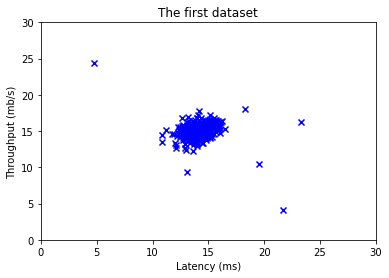

In [7]:
# Create a scatter plot of the data. To change the markers to blue "x",
# we used the 'marker' and 'c' parameters
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

<a name="2.3"></a>
### 2.3 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

### 2.3.1 Estimating parameters for a Gaussian distribution

**Implementation**: 

Your task is to complete the code in `estimate_gaussian` below.

<a name="ex01"></a>
### Exercise 1

Please complete the `estimate_gaussian` function below to calculate `mu` (mean for each feature in `X`) and `var` (variance for each feature in `X`). 

You can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, you will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [8]:
# UNQ_C1
# GRADED FUNCTION: estimate_gaussian

def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    ### START CODE HERE ### 
    
    mu = np.mean(X,axis=0)
    var = np.var(X, axis=0)
    
    ### END CODE HERE ### 
        
    return mu, var

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
  
   * You can implement this function in two ways: 
      * 1 - by having two nested for loops - one looping over the **columns** of `X` (each feature) and then looping over each data point. 
      * 2 - in a vectorized manner by using `np.sum()` with `axis = 0` parameter (since we want the sum for each column)

    
   * Here's how you can structure the overall implementation of this function for the vectorized implementation:
     ```python  
    def estimate_gaussian(X): 
        m, n = X.shape
    
        ### START CODE HERE ### 
        mu = # Your code here to calculate the mean of every feature
        var = # Your code here to calculate the variance of every feature 
        ### END CODE HERE ### 
        
        return mu, var
    ```

    If you're still stuck, you can check the hints presented below to figure out how to calculate `mu` and `var`.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate mu</b></font></summary>
           &emsp; &emsp; You can use <a href="https://numpy.org/doc/stable/reference/generated/numpy.sum.html">np.sum</a> to with `axis = 0` parameter to get the sum for each column of an array
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate mu</b></font></summary>
               &emsp; &emsp; You can compute mu as <code>mu = 1 / m * np.sum(X, axis = 0)</code>
           </details>
    </details>
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate var</b></font></summary>
           &emsp; &emsp; You can use <a href="https://numpy.org/doc/stable/reference/generated/numpy.sum.html">np.sum</a> to with `axis = 0` parameter to get the sum for each column of an array and <code>**2</code> to get the square.
          <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate var</b></font></summary>
               &emsp; &emsp; You can compute var as <code> var = 1 / m * np.sum((X - mu) ** 2, axis = 0)</code>
           </details>
    </details>
    
</details>

You can check if your implementation is correct by running the following test code:

In [9]:
# Estimate mean and variance of each feature
mu, var = estimate_gaussian(X_train)              

print("Mean of each feature:", mu)
print("Variance of each feature:", var)
    
# UNIT TEST
from public_tests import *
estimate_gaussian_test(estimate_gaussian)

Mean of each feature: [14.11222578 14.99771051]
Variance of each feature: [1.83263141 1.70974533]
All tests passed!


**Expected Output**:
<table>
  <tr>
    <td> <b>Mean of each feature: <b>  </td> 
    <td> [14.11222578 14.99771051]</td> 
   </tr>    
   <tr>
    <td> <b>Variance of each feature: <b>  </td>
     <td> [1.83263141 1.70974533] </td> 
  </tr>
</table>

Now that you have completed the code in `estimate_gaussian`, we will visualize the contours of the fitted Gaussian distribution. 

You should get a plot similar to the figure below. 
<img src="images/figure2.png" width="500" height="500">


From your plot you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

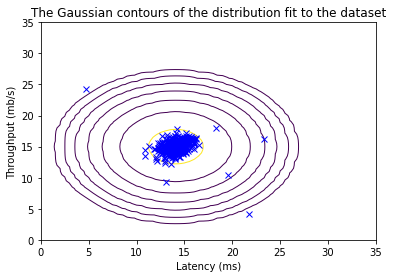

In [10]:
# Returns the density of the multivariate normal
# at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)

#Plotting code 
visualize_fit(X_train, mu, var)

### 2.3.2 Selecting the threshold $\epsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, you will complete the code in `select_threshold` to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

<a name="ex02"></a>
### Exercise 2
Please complete the `select_threshold` function below to find the best threshold to use for selecting outliers based on the results from the validation set (`p_val`) and the ground truth (`y_val`). 

* In the provided code `select_threshold`, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. 

* You need to implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
    * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
    * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
    * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

**Implementation Note:** 
In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples.


If you get stuck, you can check out the hints presented after the cell below to help you with the implementation.

In [31]:
# UNQ_C2
# GRADED FUNCTION: select_threshold

def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        ### START CODE HERE ### 
        
        val = p_val - epsilon
        
        
        ### END CODE HERE ### 
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
   
    return best_epsilon, best_F1

<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

   * Here's how you can structure the overall implementation of this function for the vectorized implementation:
     ```python  
    def select_threshold(y_val, p_val): 
        best_epsilon = 0
        best_F1 = 0
        F1 = 0
    
        step_size = (max(p_val) - min(p_val)) / 1000
    
        for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
            ### START CODE HERE ### 
            predictions = # Your code here to calculate predictions for each example using epsilon as threshold
        
            tp = # Your code here to calculate number of true positives
            fp = # Your code here to calculate number of false positives
            fn = # Your code here to calculate number of false negatives
        
            prec = # Your code here to calculate precision
            rec = # Your code here to calculate recall
        
            F1 = # Your code here to calculate F1
            ### END CODE HERE ### 
        
            if F1 > best_F1:
                best_F1 = F1
                best_epsilon = epsilon
        
        return best_epsilon, best_F1
    ```

    If you're still stuck, you can check the hints presented below to figure out how to calculate each variable.
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate predictions</b></font></summary>
           &emsp; &emsp; If an example  𝑥  has a low probability  $p(x) < \epsilon$ , then it is classified as an anomaly. To get predictions for each example (0/ False for normal and 1/True for anomaly), you can use <code>predictions = (p_val < epsilon)</code>
    </details>
    
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate tp, fp, fn</b></font></summary>
           &emsp; &emsp; 
        <ul>
          <li>If you have several binary values in an $n$-dimensional
binary vector, you can find out how many values in this vector are 0 by using:  `np.sum(v == 0)`</li>
          <li>You can also apply a logical *and* operator to such binary vectors. For instance,  `predictions` is a binary vector of the size of your number of cross validation set, where the $i$-th element is 1 if your algorithm considers $x_{\rm cv}^{(i)}$ an anomaly, and 0 otherwise. </li>
          <li>You can then, for example, compute the number of false positives using:  
<code>fp = sum((predictions == 1) & (y_val == 0))</code>.</li>
        </ul>
         <details>
              <summary><font size="2" color="blue"><b>&emsp; &emsp; More hints to calculate tp, fn</b></font></summary>
               &emsp; &emsp;
             <ul>
              <li>You can compute tp as <code> tp = np.sum((predictions == 1) & (y_val == 1))</code></li>
              <li>You can compute tn as <code> fn = np.sum((predictions == 0) & (y_val == 1))</code></li>  
              </ul>
          </details>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate precision</b></font></summary>
           &emsp; &emsp; You can calculate precision as <code>prec = tp / (tp + fp)</code>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate recall</b></font></summary>
           &emsp; &emsp; You can calculate recall as <code>rec = tp / (tp + fn)</code>
    </details>
        
    <details>
          <summary><font size="2" color="darkblue"><b>Hint to calculate F1</b></font></summary>
           &emsp; &emsp; You can calculate F1 as <code>F1 = 2 * prec * rec / (prec + rec)</code>
    </details>
    
</details>

You can check your implementation using the code below

In [32]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)
    
# UNIT TEST
select_threshold_test(select_threshold)


[4.16320668e-02 8.19090108e-02 4.07157786e-02 6.19000296e-02
 7.11867554e-02 4.24344853e-02 6.02008481e-02 8.40342100e-02
 2.10898297e-02 7.69984880e-02 7.99333934e-02 4.26414727e-02
 5.29650364e-02 1.45616238e-02 5.43344414e-02 4.40394423e-02
 4.36430996e-02 5.70196137e-02 7.61418144e-02 4.56875039e-02
 8.72843970e-02 3.48673523e-02 8.46243029e-02 7.21707760e-02
 7.35073719e-02 8.29581276e-02 4.38096439e-02 7.12890067e-02
 4.24973261e-02 6.78153446e-02 8.34299871e-02 6.26720991e-02
 7.09268159e-02 8.87683974e-02 6.38919731e-02 7.22535016e-02
 6.59214319e-02 2.41859626e-02 5.42033241e-02 8.69968693e-02
 5.65582369e-02 3.59221959e-02 6.33421399e-02 8.38169319e-02
 8.89797178e-02 7.43634297e-02 3.60198670e-02 8.51344681e-02
 7.53586064e-02 6.23436228e-02 4.89475372e-02 8.92182546e-02
 7.62557241e-02 7.70214399e-02 4.71248125e-02 7.05709749e-02
 7.12209629e-02 5.87622164e-02 3.92631966e-02 6.67794115e-02
 8.85680870e-02 4.79502030e-02 8.21988040e-02 3.83103297e-02
 6.48215020e-02 4.342680

 -9.43121154e-03 -9.44039530e-03 -9.42384196e-03]
[ 3.21017628e-02  7.23787068e-02  3.11854746e-02  5.23697257e-02
  6.16564514e-02  3.29041813e-02  5.06705441e-02  7.45039061e-02
  1.15595258e-02  6.74681840e-02  7.04030895e-02  3.31111687e-02
  4.34347324e-02  5.03131984e-03  4.48041375e-02  3.45091383e-02
  3.41127957e-02  4.74893098e-02  6.66115104e-02  3.61571999e-02
  7.77540931e-02  2.53370484e-02  7.50939989e-02  6.26404720e-02
  6.39770679e-02  7.34278237e-02  3.42793399e-02  6.17587028e-02
  3.29670221e-02  5.82850406e-02  7.38996832e-02  5.31417952e-02
  6.13965119e-02  7.92380934e-02  5.43616692e-02  6.27231976e-02
  5.63911279e-02  1.46556587e-02  4.46730201e-02  7.74665653e-02
  4.70279330e-02  2.63918919e-02  5.38118359e-02  7.42866279e-02
  7.94494139e-02  6.48331258e-02  2.64895631e-02  7.56041642e-02
  6.58283024e-02  5.28133189e-02  3.94172332e-02  7.96879506e-02
  6.67254202e-02  6.74911360e-02  3.75945085e-02  6.10406710e-02
  6.16906590e-02  4.92319124e-02  2.9732

 -0.01760552]
[ 0.02392009  0.06419703  0.0230038   0.04418805  0.05347478  0.02472251
  0.04248887  0.06632223  0.00337785  0.05928651  0.06222141  0.02492949
  0.03525306 -0.00315036  0.03662246  0.02632746  0.02593112  0.03930763
  0.05842983  0.02797552  0.06957242  0.01715537  0.06691232  0.0544588
  0.05579539  0.06524615  0.02609766  0.05357703  0.02478535  0.05010336
  0.06571801  0.04496012  0.05321484  0.07105642  0.04617999  0.05454152
  0.04820945  0.00647398  0.03649134  0.06928489  0.03884626  0.01821022
  0.04563016  0.06610495  0.07126774  0.05665145  0.01830789  0.06742249
  0.05764663  0.04463164  0.03123556  0.07150627  0.05854374  0.05930946
  0.02941283  0.05285899  0.05350898  0.04105024  0.02155122  0.04906743
  0.07085611  0.03023822  0.06448682  0.02059835  0.04710952  0.02571482
  0.05138634  0.07095242  0.01383987  0.06189049  0.0383691   0.06801542
  0.02089522  0.06994083  0.05927354  0.06004256  0.02977537  0.03702091
 -0.00218739  0.04148487  0.01560997  

 -0.02830463]
[ 0.01322097  0.05349792  0.01230468  0.03348893  0.04277566  0.01402339
  0.03178975  0.05562312 -0.00732127  0.04858739  0.0515223   0.01423038
  0.02455394 -0.01384947  0.02592335  0.01562835  0.015232    0.02860852
  0.04773072  0.01727641  0.0588733   0.00645626  0.05621321  0.04375968
  0.04509628  0.05454703  0.01539855  0.04287791  0.01408623  0.03940425
  0.05501889  0.034261    0.04251572  0.0603573   0.03548088  0.04384241
  0.03751034 -0.00422513  0.02579223  0.05858577  0.02814714  0.0075111
  0.03493105  0.05540584  0.06056862  0.04595233  0.00760877  0.05672337
  0.04694751  0.03393253  0.02053644  0.06080716  0.04784463  0.04861035
  0.01871372  0.04215988  0.04280987  0.03035112  0.0108521   0.03836832
  0.06015699  0.01953911  0.05378771  0.00989923  0.03641041  0.01501571
  0.04068723  0.0602533   0.00314075  0.05119137  0.02766998  0.05731631
  0.01019611  0.05924172  0.04857442  0.04934345  0.01907626  0.02632179
 -0.01288651  0.03078575  0.00491086  

 -0.03666613]
[ 4.85947892e-03  4.51364229e-02  3.94319072e-03  2.51274418e-02
  3.44141675e-02  5.66189742e-03  2.34282602e-02  4.72616222e-02
 -1.56827582e-02  4.02259001e-02  4.31608055e-02  5.86888483e-03
  1.61924485e-02 -2.22109641e-02  1.75618536e-02  7.26685438e-03
  6.87051174e-03  2.02470258e-02  3.93692265e-02  8.91491599e-03
  5.05118091e-02 -1.90523557e-03  4.78517150e-02  3.53981881e-02
  3.67347840e-02  4.61855398e-02  7.03705601e-03  3.45164188e-02
  5.72473820e-03  3.10427567e-02  4.66573993e-02  2.58995113e-02
  3.41542280e-02  5.19958095e-02  2.71193853e-02  3.54809137e-02
  2.91488440e-02 -1.25866252e-02  1.74307362e-02  5.02242814e-02
  1.97856491e-02 -8.50392016e-04  2.65695520e-02  4.70443440e-02
  5.22071300e-02  3.75908418e-02 -7.52720855e-04  4.83618803e-02
  3.85860185e-02  2.55710349e-02  1.21749493e-02  5.24456667e-02
  3.94831363e-02  4.02488521e-02  1.03522246e-02  3.37983870e-02
  3.44483751e-02  2.19896285e-02  2.49060873e-03  3.00068237e-02
  5.1795499

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[-4.75571928e-02 -7.28024880e-03 -4.84734810e-02 -2.72892299e-02
 -1.80025042e-02 -4.67547743e-02 -2.89884115e-02 -5.15504952e-03
 -6.80994299e-02 -1.21907716e-02 -9.25586617e-03 -4.65477869e-02
 -3.62242232e-02 -7.46276358e-02 -3.48548181e-02 -4.51498173e-02
 -4.55461600e-02 -3.21696459e-02 -1.30474452e-02 -4.35017557e-02
 -1.90486257e-03 -5.43219073e-02 -4.56495671e-03 -1.70184836e-02
 -1.56818877e-02 -6.23113193e-03 -4.53796157e-02 -1.79002529e-02
 -4.66919335e-02 -2.13739150e-02 -5.75927243e-03 -2.65171604e-02
 -1.82624437e-02 -4.20862189e-04 -2.52972864e-02 -1.69357580e-02
 -2.32678277e-02 -6.50032969e-02 -3.49859355e-02 -2.19239031e-03
 -3.26310226e-02 -5.32670637e-02 -2.58471197e-02 -5.37232772e-03
 -2.09541735e-04 -1.48258299e-02 -5.31693926e-02 -4.05479144e-03
 -1.38306532e-02 -2.68456368e-02 -4.02417224e-02  2.89949948e-05
 -1.29335354e-02 -1.21678196e-02 -4.20644471e-02 -1.86182847e-02
 -1.79682967e-02 -3.04270432e-02 -4.99260630e-02 -2.24098480e-02
 -6.21172581e-04 -4.12390

  0.1482  0.1582  0.1682]
[-0.12209 -0.11209 -0.10209 -0.09209 -0.08209 -0.07209 -0.06209 -0.05209
 -0.04209 -0.03209 -0.02209 -0.01209 -0.00209  0.00791  0.01791  0.02791
  0.03791  0.04791  0.05791  0.06791  0.07791  0.08791  0.09791  0.10791
  0.11791  0.12791  0.13791  0.14791  0.15791  0.16791]
[-0.12238 -0.11238 -0.10238 -0.09238 -0.08238 -0.07238 -0.06238 -0.05238
 -0.04238 -0.03238 -0.02238 -0.01238 -0.00238  0.00762  0.01762  0.02762
  0.03762  0.04762  0.05762  0.06762  0.07762  0.08762  0.09762  0.10762
  0.11762  0.12762  0.13762  0.14762  0.15762  0.16762]
[-0.12267 -0.11267 -0.10267 -0.09267 -0.08267 -0.07267 -0.06267 -0.05267
 -0.04267 -0.03267 -0.02267 -0.01267 -0.00267  0.00733  0.01733  0.02733
  0.03733  0.04733  0.05733  0.06733  0.07733  0.08733  0.09733  0.10733
  0.11733  0.12733  0.13733  0.14733  0.15733  0.16733]
[-0.12296 -0.11296 -0.10296 -0.09296 -0.08296 -0.07296 -0.06296 -0.05296
 -0.04296 -0.03296 -0.02296 -0.01296 -0.00296  0.00704  0.01704  0.02704
  0

 -2.0130e-02 -1.0130e-02 -1.3000e-04  9.8700e-03  1.9870e-02  2.9870e-02]
[-0.26042 -0.25042 -0.24042 -0.23042 -0.22042 -0.21042 -0.20042 -0.19042
 -0.18042 -0.17042 -0.16042 -0.15042 -0.14042 -0.13042 -0.12042 -0.11042
 -0.10042 -0.09042 -0.08042 -0.07042 -0.06042 -0.05042 -0.04042 -0.03042
 -0.02042 -0.01042 -0.00042  0.00958  0.01958  0.02958]
[-0.26071 -0.25071 -0.24071 -0.23071 -0.22071 -0.21071 -0.20071 -0.19071
 -0.18071 -0.17071 -0.16071 -0.15071 -0.14071 -0.13071 -0.12071 -0.11071
 -0.10071 -0.09071 -0.08071 -0.07071 -0.06071 -0.05071 -0.04071 -0.03071
 -0.02071 -0.01071 -0.00071  0.00929  0.01929  0.02929]
[-0.261 -0.251 -0.241 -0.231 -0.221 -0.211 -0.201 -0.191 -0.181 -0.171
 -0.161 -0.151 -0.141 -0.131 -0.121 -0.111 -0.101 -0.091 -0.081 -0.071
 -0.061 -0.051 -0.041 -0.031 -0.021 -0.011 -0.001  0.009  0.019  0.029]
[-0.26129 -0.25129 -0.24129 -0.23129 -0.22129 -0.21129 -0.20129 -0.19129
 -0.18129 -0.17129 -0.16129 -0.15129 -0.14129 -0.13129 -0.12129 -0.11129
 -0.10129 -0.091

AssertionError: Wrong best_epsilon. Expected: 0.04 got: 0

**Expected Output**:
<table>
  <tr>
    <td> <b>Best epsilon found using cross-validation: <b>  </td> 
    <td> 8.99e-05</td> 
   </tr>    
   <tr>
    <td> <b>Best F1 on Cross Validation Set: <b>  </td>
     <td> 0.875 </td> 
  </tr>
</table>

Now we will run your anomaly detection code and circle the anomalies in the plot (Figure 3 below).

<img src="images/figure3.png" width="500" height="500">

In [ ]:
# Find the outliers in the training set 
outliers = p < epsilon

# Visualize the fit
visualize_fit(X_train, mu, var)

# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

<a name="2.4"></a>
### 2.4 High dimensional dataset

Now,  we will run the anomaly detection algorithm that you implemented on a more realistic and much harder dataset.

In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

Let's start by loading the dataset.

- The `load_data()` function shown below loads the data into variables `X_train_high`, `X_val_high` and `y_val_high`
    -  `_high` is meant to distinguish these variables from the ones used in the previous part
    - We will use `X_train_high` to fit Gaussian distribution 
    - We will use `X_val_high` and `y_val_high` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [ ]:
# load the dataset
X_train_high, X_val_high, y_val_high = load_data_multi()

#### Check the dimensions of your variables

Let's check the dimensions of these new variables to become familiar with the data

In [ ]:
print ('The shape of X_train_high is:', X_train_high.shape)
print ('The shape of X_val_high is:', X_val_high.shape)
print ('The shape of y_val_high is: ', y_val_high.shape)

#### Anomaly detection 

Now, let's run the anomaly detection algorithm on this new dataset.

The code below will use your code to 
* Estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$)
* Evaluate the probabilities for both the training data `X_train_high` from which you estimated the Gaussian parameters, as well as for the the cross-validation set `X_val_high`. 
* Finally, it will use `select_threshold` to find the best threshold $\varepsilon$. 

In [ ]:
# Apply the same steps to the larger dataset

# Estimate the Gaussian parameters
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

**Expected Output**:
<table>
  <tr>
    <td> <b>Best epsilon found using cross-validation: <b>  </td> 
    <td> 1.38e-18</td> 
   </tr>    
   <tr>
    <td> <b>Best F1 on Cross Validation Set: <b>  </td>
     <td> 0.615385 </td> 
  </tr>
    <tr>
    <td> <b># anomalies found: <b>  </td>
     <td>  117 </td> 
  </tr>
</table>

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://lh3.google.com/u/0/d/14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>